# VarGam visualization (by Ikram El Khanba and revisited by Botao Li, under the supervision of Lokman Abbas Turki)

In this notebook, we examine the call prices generated by VarGam model and their neural network approximation.

In the Variance Gamma model, the asset price is modeled as the exponential of a Variance Gamma process. This Lévy process can be represented via Brownian subordination, that is to say, written as a Brownian motion with drift at random times given by a Gamma process. Let subordinator $Z_t / \kappa$ be a Gamma process of distribution $\Gamma(t/\kappa, 1)$. The variance Gamma process is described by the following dynamics:

$$
{X}_{\text{VG}}(t;\kappa, \sigma_{\text{VG}}, \theta) := \theta Z_t + \sigma_{\text{VG}} W(Z_t),
$$

An asset $S(t)$ is governed by the exponential VG dynamics if

$$
S_t = S_0 e^{X_{\text{VG}}(t)},
$$

There are three free parameters in total, they are $\kappa, \theta$, and $\sigma_{\text{VG}}$. The initial values of the asset price $S_0$ is set to one. 

The price of the call option is the expectation of the payoff in the risk free measure:

$$
C(T, K, \kappa, \theta,\sigma_{\text{VG}}) = \mathbb{E}[(S_T - K)^+].
$$

The prices $\hat{C}$ in the database is generated via Monte Carlo simulation such that $\hat{C}(T, K, \kappa, \theta,\sigma_{\text{VG}}) = \hat{\mathbb{E}}[(S_T - K)^+]$, where $\hat{\mathbb{E}}$ denote the empirical expectation. The parameters are stored with the $\hat{C}$ and its confidence interval in the csv files whose names contain strike and maturity. We train a neural network $f(T, K, \kappa, \theta,\sigma_{\text{VG}})\approx \hat{C}(T, K, \kappa, \theta,\sigma_{\text{VG}})$ to approximate the Monte Carlo price.

In [1]:
from numba import cuda
import numpy as np
from scipy.stats import norm
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import os
import copy
import scipy.stats as stats
from sklearn.metrics import r2_score
import polars as pl
import re
device = torch.device('cpu') 

## Reading data

The .csv data files are organized into separate folders based on their usage: train, validation, and test. Within each folder, model parameters, prices, and their 95% confidence intervals are stored in files named according to the strike and maturity. 

In [2]:
import os
import shutil

# Paths to the folders
inference_data_folder =  r'Testing/normalsizeinference'  
testing_data_folder = r'Testing/Test'      
validation_data_folder = r'Testing/Validation'  

# Create the testing and validation folders if they don't exist
os.makedirs(testing_data_folder, exist_ok=True)
os.makedirs(validation_data_folder, exist_ok=True)

# List all files in the inference_data folder
files = os.listdir(inference_data_folder)

# Loop through files and distribute them alternately
for i, filename in enumerate(files):
    source_file = os.path.join(inference_data_folder, filename)
    
    if i % 2 == 0:
        destination_folder = testing_data_folder
    else:
        destination_folder = validation_data_folder
    
    # Move the file to the appropriate folder
    shutil.move(source_file, os.path.join(destination_folder, filename))

print("Files have been successfully divided into testing and validation datasets.")

Files have been successfully divided into testing and validation datasets.


In [3]:
def read_data(path):
    """
    Reads and combines CSV data files from a specified folder, adding 'maturity' and 'strike' 
    columns extracted from filenames.

    Args:
        path (str): Relative path to the folder containing CSV data files.

    Returns:
        pl.DataFrame: A Polars DataFrame containing the combined data from all CSV files, 
                      with added 'maturity' and 'strike' columns.
    """
    # Get the list of all files in the specified folder
    file_list = os.listdir(path)
    file_list.sort()  # Ensure files are processed in a sorted order

    df = pl.DataFrame()  # Initialize an empty Polars DataFrame

    # Loop over all files in the folder
    for filename in file_list:
        reader = pl.read_csv(path + '/' + filename)  # Read CSV file into a Polars DataFrame
        
        # Use regular expressions to extract 'maturity' and 'strike' values from the filename
        TK = re.findall(r"\d\.\d{4}", filename)
        
        # Append the data with the extracted 'maturity' and 'strike' columns
        df = pl.concat([
            df, 
            reader.with_columns(
                pl.lit(float(TK[0])).alias("maturity"), 
                pl.lit(float(TK[1])).alias("strike")
            )
        ], how='vertical')

    # Clean up string columns and convert them to Float64
    for col in df.columns:
        if df[col].dtype == pl.String:
            df = df.with_columns(
                pl.col(col).str.strip_chars().cast(pl.Float64).alias(col.strip())  # Trim and cast to Float64
            )
            df = df.drop(col)  # Drop the original string column

    return df

In [4]:
df = read_data(r'Testing/Test') # Relative path to the testing data directory
print(df.shape)
df = df.filter(df['error'] <= df['price']) # remove the data points that are not significantly away from zero
print(df.shape)

(120000, 7)
(120000, 7)


In [5]:
input_columns = ['maturity', 'strike', 'kappa', 'sigma', 'theta']  # Select only relevant features
target_column = ['price']  # The target column

X_test = torch.tensor(df[input_columns].to_numpy(), dtype=torch.float32).to(device)
Y_test = df[target_column].to_numpy()[:, 0]
error_test = df[["error"]].to_numpy()[:, 0]

## Reading the pre-trained model

In this part we read the pre-trained model and provide its outputs for the inputs from the Testing/Test files

In [6]:
n_input = len(input_columns)
n_output = 1

class net(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_hidden3, n_output, GeLU=False, soft=False):
        """
        :param n_input: number of perceptrons for the input layer (int)
        :param n_hidden: number of perceptrons for the hidden layer (int)
        :param n_output: number of perceptrons for the output layer (int)
        """
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.hidden3 = nn.Linear(n_hidden2, n_hidden3)
        self.output = nn.Linear(n_hidden3, n_output)
        self.nonlin = nn.ReLU()
        if GeLU:
            self.nonlin = nn.GELU()
        self.out = lambda x : x
        if soft:
            self.out = nn.Softplus()


    def forward(self, x):
        """
        :param x: Neural network input (2d torch tensor with arbitrary number of rows and n_input columns)
        :return: 2d torch tensor: Neural network output (same number of rows as x, n_output columns)
        """
        x = self.nonlin(self.hidden1(x))
        x = self.nonlin(self.hidden2(x))
        x = self.nonlin(self.hidden3(x))
        x = self.output(x)
        return self.out(x)  


def read_model(path, arch, *args):
    """
    Loads a trained PyTorch model from a checkpoint file.

    Args:
        path (str): Path to the checkpoint file.
        arch (torch.nn.Module): Model architecture class or function.
        *args: Additional arguments required to initialize the model architecture.

    Returns:
        torch.nn.Module: The loaded model in evaluation mode.
    """
    # Load the checkpoint file, ensuring compatibility with the current device
    checkpoint = torch.load(path, map_location=device)
    
    # Initialize the model using the provided architecture and arguments
    model = arch(*args)
    
    # Load the saved model weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Set the model to evaluation mode (disables dropout, batch norm updates, etc.)
    model.eval()
    
    return model

In [7]:
# Pretrained best model
model_best = read_model('model_checkpoints/best_model.pth', net, n_input, 200, 200, 200, n_output).to(device)

In [8]:
# Results of prediction
with torch.no_grad():
    pred_best = model_best(X_test).squeeze().detach().cpu().numpy()

## Evaluation of Model Performance

To evaluate the model’s performance, we conducted statistical analyses on the test set:


### 1. Model Fit
- We compared the model’s predictions with the actual test values by plotting the predictions against the targets. 
- A regression line was added, and the $R^2$ score was calculated to assess accuracy. 

In [9]:
# Function to plot data with regression line and R value
def plot_with_fit_line(ax, targets, predictions, title, color):
    minmax = np.array([min(targets), max(targets)])
    ax.scatter(targets, predictions, label='Data', marker='.', color='black', alpha=0.3)
    ax.plot(minmax, minmax, label=r'$\hat{C}$ = C', color=color, linestyle='-')
    
    # Fit line (linear regression) and R value
    m, b = np.polyfit(targets, predictions, 1)
    r_value = r2_score(targets, predictions)
    
    ax.plot(minmax, m*minmax + b, label=f'Fit (R={r_value:.5f})', color=color)
    ax.set_title(title)
    ax.set_xlabel('Target')
    ax.set_ylabel(f'Output = {m:.2f}*Target + {b:.2f}')
    ax.legend()
    ax.grid(True)

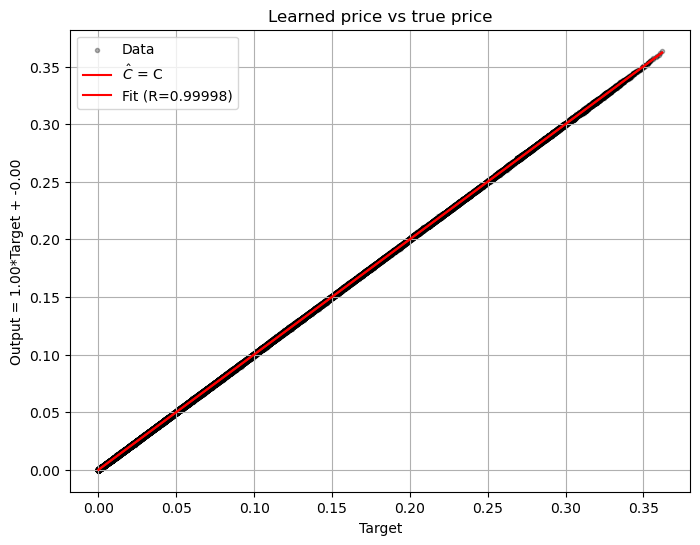

In [10]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot testing data
plot_with_fit_line(ax, Y_test, pred_best, "Learned price vs true price", 'red')

# Save or show the plot
#plt.savefig('OU_predictions_vs_target.png')
plt.show()


### 2. Maximum Relative Error
- As the generate price can be zero, maximum relative error among all data points does not make much sense. As long as the true price is close enough to zero, a small error can always generate large enough relative error. Thus, we constrain ourselves to apply the maximum relative error to prices larger than a certain threshold, namely  To compute the maximum relative error, we first filtered the data, selecting only non-null values that exceed a specified threshold, 3×max(error, 10−2), where error denote the Monte Carlo error for the true price.
- The maximum relative error is computed as  

$$
\text{Maximum Relative Error} = \max \left( \frac{|\hat{y} - y|}{|y|} \right)
$$

where $\hat{y}$ represents the predicted value and $y$ is the true value.
- Plots are then generated to visualize how many data points data are dropped in the filtering process, ensuring that a sufficient percentage of the data remains to avoid biasing the results due to excessive filtration. 
- The figures also serve as a visual comparison of the distribution of the true and approximated price. Although the empirical CDF provide a better quantitative comparison of the distribution, we choose to use histograms as it is easier to recognize the well and badly performancing region in a histogram.
  


In [11]:
def hist_pred(pred, target, errors):
    # Extract predicted prices
    val_price_predictions = np.array(pred[:])

    # Extract the actual prices from the validation targets
    val_actual_prices = np.array(target[:])

    #error_column=['95cI']
    val_actual_errors = np.array(errors[:]) #df[error_column].to_numpy()[:, 0] # Actual errors

    # Filter out rows where actual price is 0 
    non_zero_indices = val_actual_prices != 0  # Only filtering out 0 prices
    val_price_predictions = val_price_predictions[non_zero_indices]
    val_actual_prices = val_actual_prices[non_zero_indices]
    val_actual_errors = val_actual_errors[non_zero_indices]  # Keeping actual errors for possible later analysis

    # Compute a threshold based on the maximum of 3 * val_actual_errors and 1e-2
    threshold = np.maximum(3 * val_actual_errors, 1e-2)

    # Determine valid indices where val_price_predictions > threshold
    valid_val_indices = val_actual_prices > threshold
    filtered_val_predictions = val_price_predictions[valid_val_indices]  # Filtered predicted prices
    filtered_val_actual_prices = val_actual_prices[valid_val_indices]    # Filtered actual prices

    # Compute relative error for the filtered validation data
    val_relative_errors = np.abs(filtered_val_predictions - filtered_val_actual_prices) / filtered_val_actual_prices

    # Find the maximum relative error in the validation set
    max_val_relative_error = val_relative_errors.max()

    # Print results
    print(f'Maximum Relative Error (Test): {max_val_relative_error:.4f}')

    # Calculate the number of predictions before and after filtering
    num_total_predictions = len(pred_best)
    num_filtered_predictions = len(filtered_val_predictions)

    # Calculate the percentage of data points before and after filtering
    percentage_before_filtering = (num_total_predictions / len(Y_test)) * 100
    percentage_after_filtering = (num_filtered_predictions / len(Y_test)) * 100

    # Print the percentages
    print(f'Percentage of data points before filtering: {percentage_before_filtering:.2f}%')
    print(f'Percentage of data points after filtering: {percentage_after_filtering:.2f}%')

    # Plot histograms for actual and predicted prices before filtering
    plt.figure(figsize=(14, 6))

    bins = np.linspace(0, max(val_actual_prices), 50)
    plt.subplot(1, 2, 1)
    plt.hist(val_actual_prices, bins=bins, alpha=0.5, label='Actual Prices (Before Filtering)', color='blue')
    plt.hist(val_price_predictions, bins=bins, alpha=0.5, label='Predicted Prices (Before Filtering)', color='orange')
    plt.title('Price Distribution Before Filtering')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.legend()

    # Plot histograms for actual and predicted prices after filtering
    plt.subplot(1, 2, 2)
    plt.hist(filtered_val_actual_prices, bins=bins, alpha=0.5, label='Actual Prices (After Filtering)', color='blue')
    plt.hist(filtered_val_predictions, bins=bins, alpha=0.5, label='Predicted Prices (After Filtering)', color='orange')
    plt.title('Price Distribution After Filtering')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()

    # Save the plot or show it
    #plt.savefig('filtered_vs_unfiltered_prices_histogram.png')
    plt.show()

Maximum Relative Error (Test): 0.1073
Percentage of data points before filtering: 100.00%
Percentage of data points after filtering: 92.69%


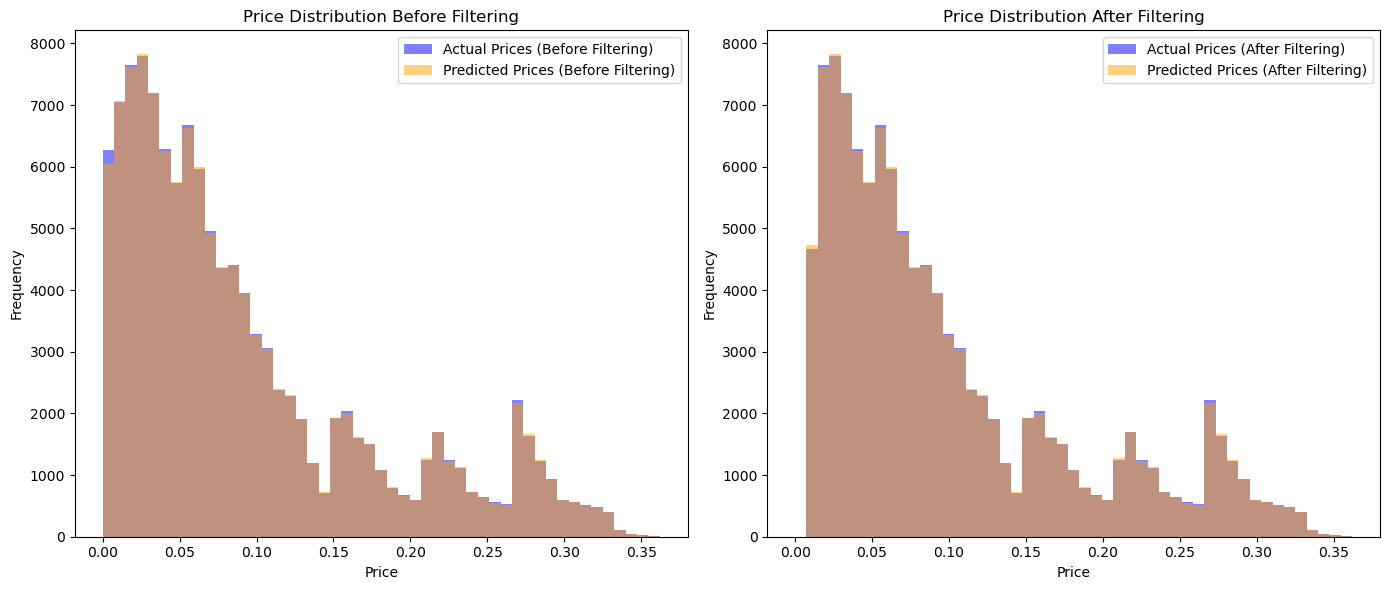

In [12]:
hist_pred(pred_best, Y_test, error_test)

### 3. Goodness of fit close to zero

- Here we focus on the data points that are not considered in the maximum relative error analysis. 
- We perform a goodness of fit test to these data points.
- If the prediction is too far away from the fit, we save the data point for possible further analysis.

In [13]:
def plot_zero(pred, target):
    # Get the predictions and targets
    test_predictions = pred
    test_targets = target

    # Filter the predictions and targets based on the condition
    filtered_indices = test_predictions <= 1e-2
    test_predictions = test_predictions[filtered_indices]
    test_targets = test_targets[filtered_indices]

    filtered_indices_targets = test_targets <= 1e-2
    test_predictions = test_predictions[filtered_indices_targets]
    test_targets = test_targets[filtered_indices_targets]

    # Plot testing data
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_with_fit_line(ax, test_targets, test_predictions, "Test", 'red')

    # Save or show the plot
    #plt.savefig('OU_predictions_vs_target_Zoom.png')
    plt.show()


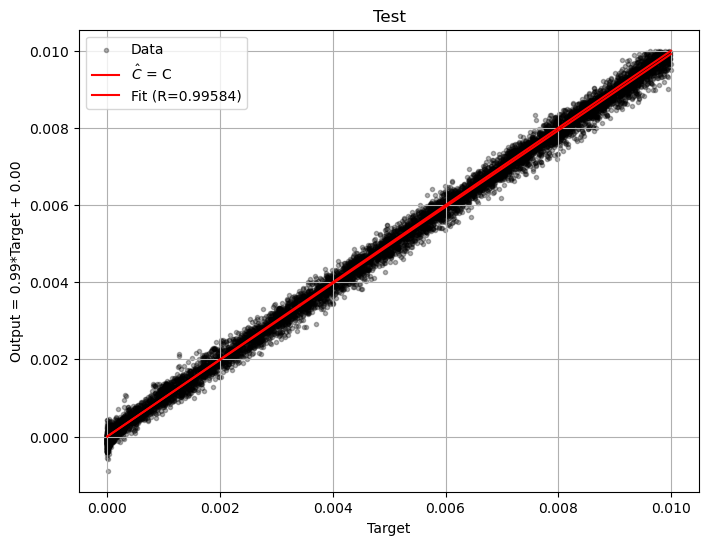

In [14]:
plot_zero(pred_best, Y_test)

We can store data points where the difference between the Monte Carlo price and the learned price is significantly large.

In [15]:
def diverge_prices(pred, target, features, file_path='diverging_prices.csv'):
    test_predictions = np.array(pred[:])  # Only get the first column for price predictions
    test_targets = np.array(target[:])
    test_input_parameters = np.array(features)

    # Filter based on target values being in the range of interest (0.00 to 0.002)
    diverging_region_indices = (test_targets >= 0.00) & (test_targets <= 0.002)

    # Filter for significant divergence: where the absolute difference between predicted and actual is large
    divergence_threshold = 0.0005  
    diverging_indices = np.abs(test_predictions - test_targets) > divergence_threshold

    # Combine both filters (targets in the range and significant divergence)
    final_filtered_indices = diverging_region_indices & diverging_indices

    # Filter the predictions, targets, strikes, and input parameters using the final indices
    diverging_predictions = test_predictions[final_filtered_indices]
    diverging_targets = test_targets[final_filtered_indices]
    diverging_input_parameters = test_input_parameters[final_filtered_indices]

    # Create a DataFrame with the filtered input parameters and the corresponding diverging prices
    diverging_prices_df = pd.DataFrame(diverging_input_parameters, columns=input_columns)
    diverging_prices_df['Predicted Price'] = diverging_predictions
    diverging_prices_df['Actual Price'] = diverging_targets

    # Display the DataFrame
    print("Input parameters corresponding to the diverging prices:")
    print(diverging_prices_df)

    #Save the diverging prices data in a file  
    diverging_prices_df.to_csv(file_path, index=False)

In [16]:
diverge_prices(pred_best, Y_test, df[input_columns].to_numpy())

Input parameters corresponding to the diverging prices:
    maturity  strike  kappa  sigma  theta  Predicted Price  Actual Price
0       0.25  1.0515  0.035  0.075 -0.255         0.002452      0.001936
1       0.25  1.0515  0.305  0.045 -0.205         0.001045      0.000326
2       0.25  1.0515  0.305  0.075 -0.205         0.002214      0.001630
3       0.25  1.0515  0.355  0.045 -0.205         0.001072      0.000317
4       0.25  1.0515  0.355  0.075 -0.205         0.002164      0.001566
5       0.25  1.0515  0.405  0.045 -0.205         0.000952      0.000304
6       0.25  1.0515  0.405  0.075 -0.205         0.002028      0.001499
7       0.50  1.0918  0.705  0.045 -0.205         0.001815      0.001249
8       0.50  1.0918  0.755  0.045 -0.205         0.002142      0.001272
9       0.50  1.0918  0.755  0.075 -0.055         0.001334      0.000828
10      0.50  1.0918  0.805  0.045 -0.205         0.002089      0.001271
11      0.50  1.0918  0.855  0.045 -0.205         0.001837      0.00

### 4. Monotonicity
- As long as the model is arbitrage free, the price is a monotonic function with respect to both strike and maturity.

- For each set of parameter in the test dataset, we sample a maturity-strike pair. The maturities are sampled from a uniform distribution, and the strike are sampled from log-uniform distributions whose scale depends on the maturity. The range of maturities and strikes are tuned so that they cover the maturities and strikes in the dataset. From now on, we use the test parameters together with the sampled maturity and strikes.

- We bump the maturity and strike by 1% respectively, and find the numerical derivative of the price with respect to maturity and strike. Let $x$ be a vector of input features of the neural network such that $x_0$ denotes maturity and $x_1$ denotes strike. The numerical derivative is computed as $\partial_T f := (f(1.01x_0, x_1, x_2, ...) - f(x_0, x_1, x_2, ...)) / 0.01x_0$ with respect to maturity and $\partial_K f := (f(x_0, 1.01x_1, x_2, ...) - f(x_0, x_1, x_2, ...)) / 0.01x_1$ with respect to strike.

- Denote the sets of numerical derivatives evaluated in the test dataset with sampled $T$ and $K$ as $\{(\partial_Tf)_i\}$ and $\{(\partial_Kf)_i\}$. We use $\sum_i (((\partial_Tf)_i)^-)^2$ and $\sum_i \left(((\partial_Kf)_i)^+\right)^2$ to characterize the total strength of non-monotonicity. Also $\sqrt{\sum_i (((\partial_Tf)_i)^-)^2 / n^-}$ and $\sqrt{\sum_i (((\partial_Kf)_i)^+)^2 / n^+}$ are used to denote the average strength of non-monotonicity, where $n^-$($n^+$) denotes the number of derivatives that are negative (positive). In case $n^+ = 0$ or $n^- = 0$, the average strength is not computed. 

- If the total strength is non-zero, the learned price is not a monotonic function. If the total strength is zero, the learned function is not guaranteed to be monotonic, as this sampling-based test only check monotonicity at a finite number of points. One can increase the number of sampled strike-maturity pairs to better detect the non-monotonicity.

- We plot the learned price as a function of maturity or strike where the non-monotonicity is detected. If no non-monotonicity is detected, the price is plotted in a pre-defined grid.

In [17]:
# Check the range of the strike and maturity in the dataset
TK = df.group_by(["maturity", "strike"]).agg()
TK.filter(TK["maturity"]==2.0)

maturity,strike
f64,f64
2.0,0.7307
2.0,1.3685
2.0,1.0


In [18]:
# size of the bump
bump = 1e-2
# number of sampled strike and maturity pairs
n_mono = 1000000

Text(0.5, 1.0, 'Range of sampled T and K')

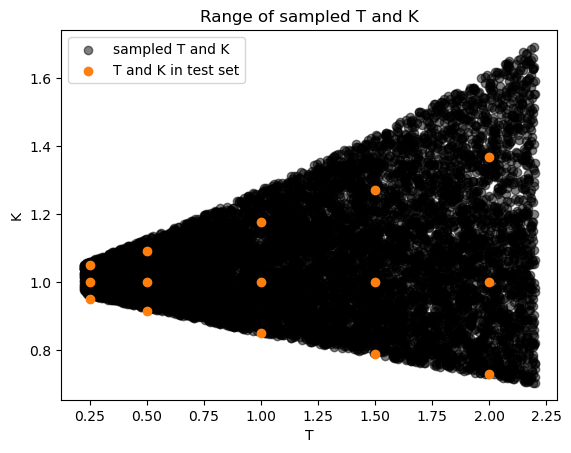

In [19]:
#sample strikes and maturities
Tmax = df["maturity"][-1] * 1.1
Tmin = df["maturity"][0] * 0.9
randT = np.random.rand(n_mono) * (Tmax - Tmin) + Tmin
#randK = np.exp(np.random.standard_normal(size=(n_mono, )) * (.05 * randT))
randK = np.exp((np.random.rand(n_mono) - 0.4) * (.4 * randT))
# scatter plot of the sampled points 
plt.scatter(randT[:min(10000, n_mono)], randK[:min(10000, n_mono)], alpha=0.5, color='k', label="sampled T and K")
plt.scatter(TK["maturity"], TK["strike"], color="C1", label="T and K in test set")
plt.xlabel("T")
plt.ylabel("K")
plt.legend()
plt.title("Range of sampled T and K")

We could verify that the T and K in the test dataset are well represented.

In [20]:
name_TK = ("maturity", "strike")

def monotonicity_check(model, direction, bump):
    """
    Checks the monotonicity of the model predictions:
    - With respect to maturity (T) when direction = 0.
    - With respect to strike (K) when direction = 1.

    Parameters:
    model : torch.nn.Module
        The trained neural network model.
    direction : int
        The direction of monotonicity check (0 for maturity, 1 for strike).
    bump : float
        The percentage bump applied to test monotonicity.

    Returns:
    positions : np.ndarray
        The parameter values (T, K) where non-monotonicity is detected.
    derivs : np.ndarray
        The corresponding numerical derivative values indicating non-monotonicity.
    """

    positions = []  # Stores feature values where non-monotonicity is detected
    derivs = []  # Stores the corresponding derivative values

    # Determine batch size to process monotonicity checks in smaller chunks
    batch_size = min(n_mono, X_test.shape[0])
    n_batches = (n_mono - 1) // batch_size + 1

    for i in range(n_batches):
        # Compute the actual batch size for the last batch
        true_batch_size = min(batch_size, n_mono - i * batch_size)

        # Create the reference input features for the monotonicity test (before bump)
        X_mono_ref = torch.tensor(X_test[:true_batch_size], device=torch.device('cpu'))
        X_mono_ref[:, 0] = torch.tensor(randT[batch_size * i: batch_size * i + true_batch_size], dtype=torch.float32)
        X_mono_ref[:, 1] = torch.tensor(randK[batch_size * i: batch_size * i + true_batch_size], dtype=torch.float32)
        X_mono_ref = X_mono_ref.to(device)

        # Create a shifted version of the inputs by applying the bump
        X_mono_shift = X_mono_ref.clone().detach()
        X_mono_shift[:, direction] *= 1 + bump  # Increase T or K slightly

        # Compute model predictions before and after the bump
        with torch.no_grad():
            pred_ref = model(X_mono_ref)  # Predictions before the bump
            pred_shift = model(X_mono_shift)  # Predictions after the bump

            # Compute the numerical first-order derivative
            num_deriv = ((pred_shift - pred_ref).squeeze() /
                         (X_mono_shift[:, direction] - X_mono_ref[:, direction])).detach().cpu().numpy()

            # Mask to filter negative derivative for maturity (T) and positive derivative for strike (K)
            mask = num_deriv * (0.5 - direction) < 0

            # Store the non-monotonic points and corresponding derivative values
            positions.append(X_mono_ref.detach().cpu().numpy()[mask])
            derivs.append(num_deriv[mask])

    # Concatenate the results across all batches
    positions = np.concatenate(positions, axis=0)
    derivs = np.concatenate(derivs, axis=0)

    if len(derivs) == 0:
        print("No non-monotonicity detected")
        return [], []

    # Compute metrics to quantify the severity of non-monotonicity
    mean_strength = np.sqrt(np.mean(derivs ** 2))  # Root mean square of non-monotonic derivatives
    total_strength = np.sum(derivs ** 2)  # Sum of squared derivatives
    max_value = max(abs(derivs))  # Maximum absolute derivative value

    # Define colors for visualization based on derivative values
    colors = [[direction, 1 - direction, 0., value / max_value] for value in abs(derivs)]

    # Plot detected non-monotonic points along with the full (T, K) distribution
    print(f'Non-monotonic mean strength: {mean_strength}, total strength: {total_strength}')
    plt.scatter(randT[:10000], randK[:10000], alpha=0.5, color='k')  # Background scatter plot
    plt.scatter(positions[:, 0], positions[:, 1], c=colors, marker='.')  # Highlight non-monotonic points
    plt.xlabel("T")
    plt.ylabel("K")
    plt.title(f"Detected non-monotonicity with respect to {name_TK[direction]}")
    plt.show()
    plt.close()

    return positions, derivs

C:\Users\lokma\AppData\Local\Temp\ipykernel_17856\607256757.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_mono_ref = torch.tensor(X_test[:true_batch_size], device=torch.device('cpu'))


Non-monotonic mean strength: 0.0022857598960399628, total strength: 0.04461369663476944


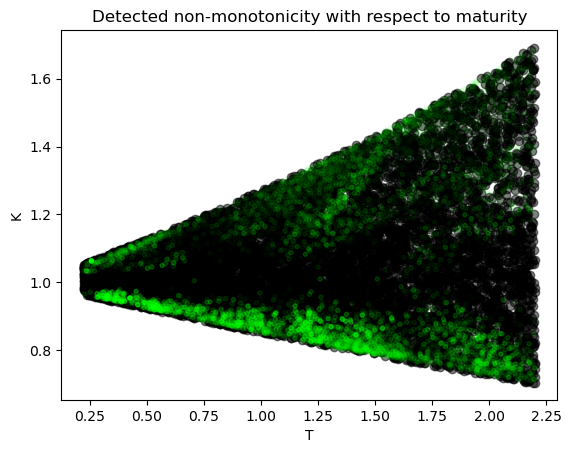

Non-monotonic mean strength: 0.0024260194040834904, total strength: 0.017962759360671043


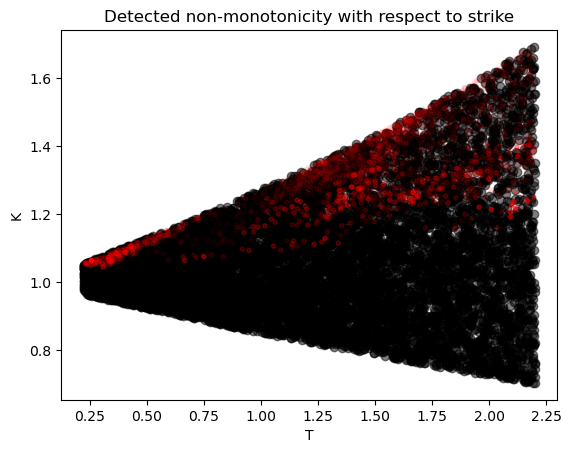

In [21]:
features_T, _ = monotonicity_check(model_best, 0, bump)
features_K, _ = monotonicity_check(model_best, 1, bump)

If non-monotonicity with respect to maturity is observed at a certain point, we keep the strike and the parameters at this point and plot the neural network as a function of maturity. 

In [22]:
# grid for plotting
n_grid = 100
# the maturity grid always start from the smallest maturity and ends at the largest maturity
grid_T = np.arange(Tmin, Tmax + (Tmax - Tmin) / n_grid, (Tmax - Tmin) / n_grid)
# the strike grid will be shifted according to the value of maturity
grid_K = np.arange(0, 1. + 1./n_grid, 1./n_grid) - 0.5

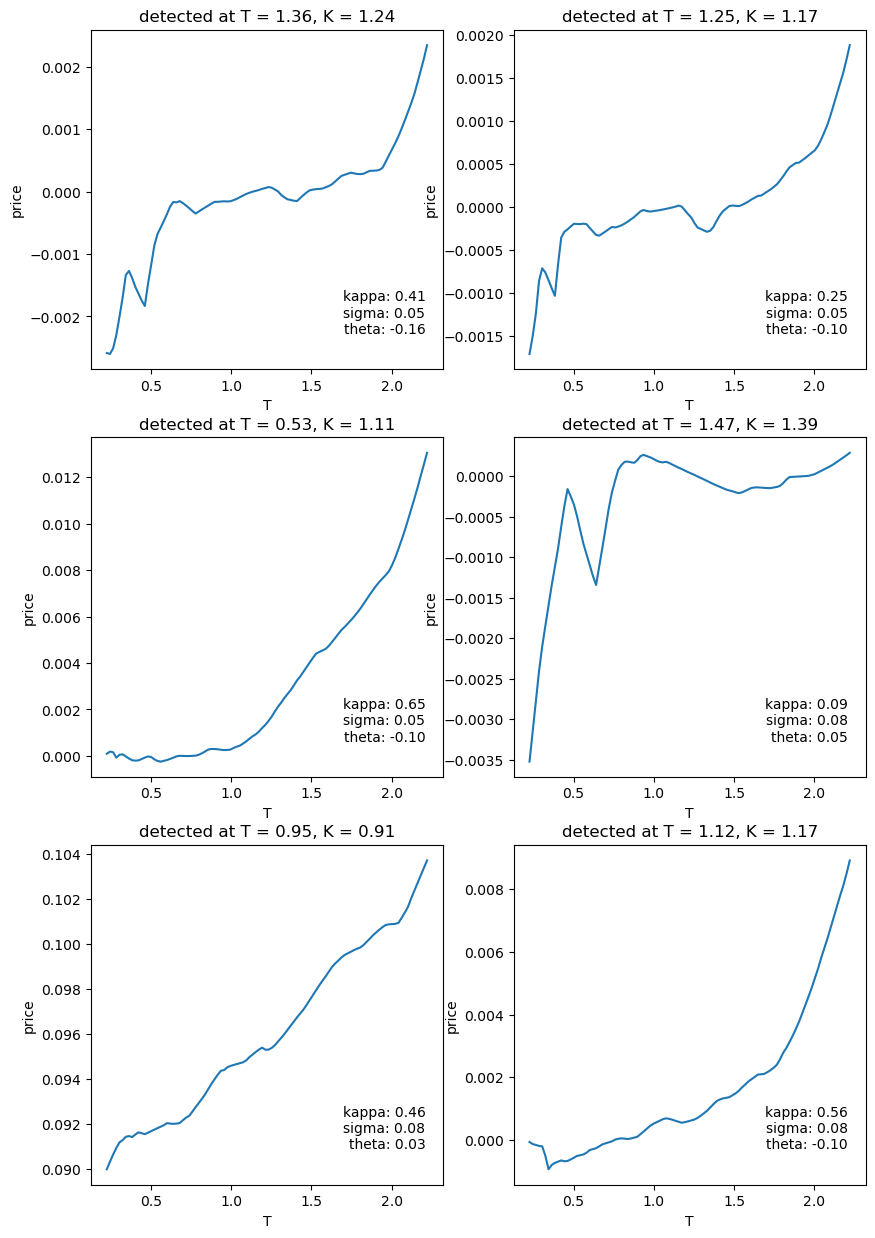

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
# sample within the points where non-monotonicity is detected
for index, i in enumerate(np.random.randint(0, features_T.shape[0], 6)):
    # create list of features that have the same parameters and strikes while having different maturity
    features_grid = np.tile(features_T[i], (len(grid_T), 1)) 
    features_grid[:, 0] = grid_T
    pred_T = model_best(torch.from_numpy(features_grid).to(device)).detach().cpu().numpy()
    axes[index//2, index%2].plot(grid_T, pred_T.squeeze())
    axes[index//2, index%2].set_title(f"detected at T = {features_T[i, 0]:.2f}, K = {features_T[i, 1]:.2f}")
    str_param = ""
    for j, name in enumerate(input_columns[2:]):
        str_param += name + f": {features_T[i, j+2]:.2f}\n"
    axes[index//2, index%2].text(0.95, 0.05, str_param, verticalalignment='bottom', horizontalalignment='right', transform=axes[index//2, index%2].transAxes)
    axes[index//2, index%2].set_xlabel("T")
    axes[index//2, index%2].set_ylabel("price")
    

If non-monotonicity with respect to strike is observed at a certain point, we keep the maturity and the parameters at this point and plot the neural network as a function of strike. 

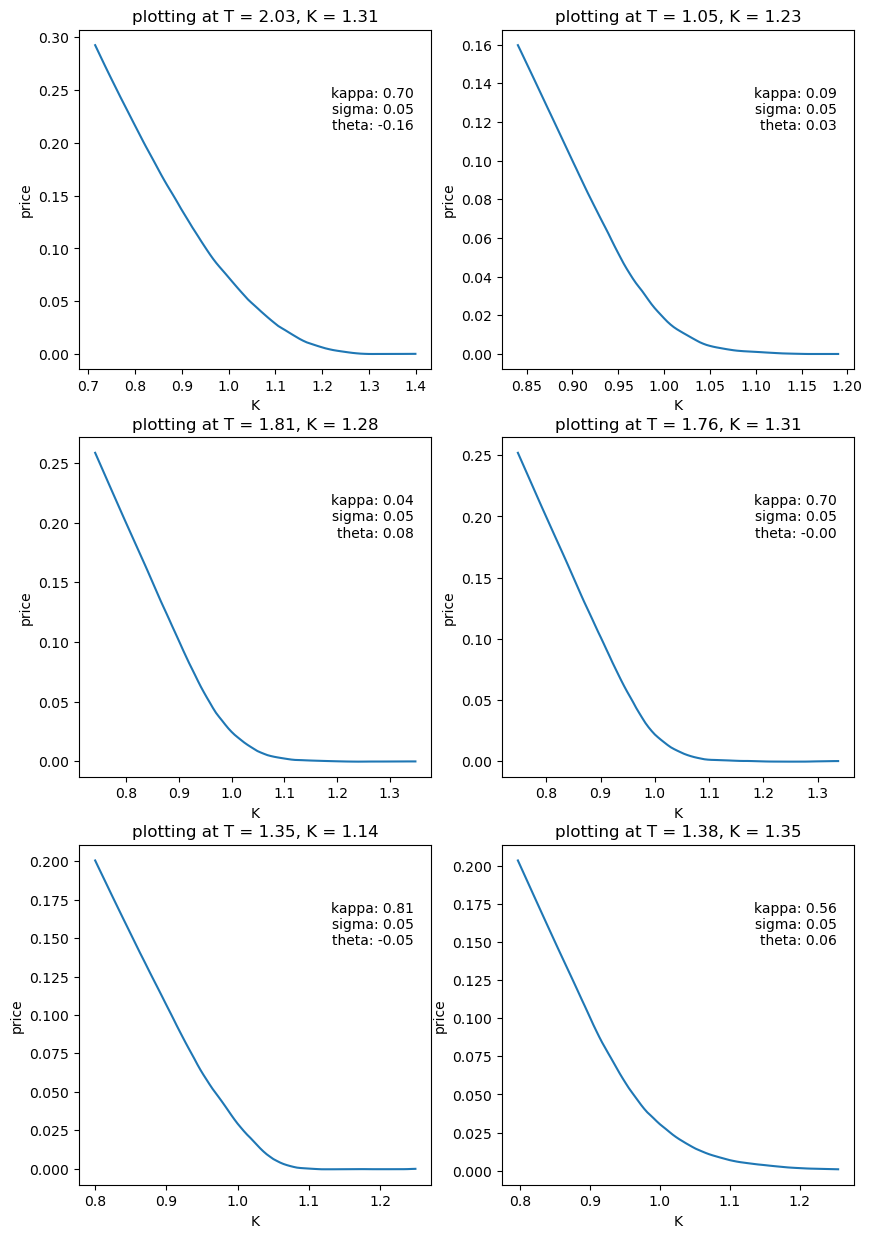

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
for index, i in enumerate(np.random.randint(0, features_K.shape[0], 6)):
    features_grid = np.tile(features_K[i], (len(grid_K), 1))
    features_grid[:, 1] = np.exp(0.33 * features_K[i, 0].item() * grid_K)
    pred_K = model_best(torch.from_numpy(features_grid).to(device)).detach().cpu().numpy()
    axes[index//2, index%2].plot(features_grid[:, 1], pred_K.squeeze())
    axes[index//2, index%2].set_title(f"plotting at T = {features_K[i, 0]:.2f}, K = {features_K[i, 1]:.2f}")
    str_param = ""
    for j, name in enumerate(input_columns[2:]):
        str_param += name + f": {features_K[i, j+2]:.2f}\n"
    axes[index//2, index%2].text(0.95, 0.65, str_param, verticalalignment='bottom', horizontalalignment='right', transform=axes[index//2, index%2].transAxes)
    axes[index//2, index%2].set_xlabel("K")
    axes[index//2, index%2].set_ylabel("price")

### 5. Convexity

 - The price is a convex function of strike. 
 
 - To detect non-convexity of the neural network, we apply the same idea of non-monotonicity detection. For each input feature $x$, we first compute the predicted price $f(x)$. Denoting $(x_0, 1.1x_1, ...)$ by $x'$, we are interested in the quantity $c(x) := f((x + x')/2) - (f(x) + f(x')) / 2$. If $c(x)$ is positive, the price is not a convex function of strike, and the non-convexity can be observed near $x$. 
  
 - We reuse the features $\{x_i\}$ generated in the non-monotonicity test, and compute $c(x_i)$. If none of $c(x_i)$ is positive, no non-convexity is detected, although there is no guarantee that the function is convex.

 - Otherwise, we use $\sum_i c^2(x_i)$ to characterize the total strength of the non-convexity, and $\sqrt{\sum_i c^2(x_i) / n^+}$ to characterize the mean strength, where $n^+$ is the number of positive $c(x_i)$. 

 - We plot the learned price as a function of strike where the non-convexity is detected. 

In [25]:
def convexity_check(model, bump):
    """
    Checks the convexity of the model predictions.

    This function tests whether the model's output is convex with respect to 
    the strike (K) by applying a bump and evaluating deviations from convexity
    in the interval between K and bumped K.

    Parameters:
    model : torch.nn.Module
        The trained neural network model.
    bump : float
        The percentage bump applied to test convexity.

    Returns:
    positions : np.ndarray
        The parameter values (T, K) where non-convexity is detected.
    values : np.ndarray
        The corresponding numerical values indicating non-convexity.
    """

    positions = []  # Stores feature values where non-convexity is detected
    values = []  # Stores c(x) values where non-convexity is detected

    # Determine batch size to process convexity checks in smaller chunks
    batch_size = min(n_mono, X_test.shape[0])
    n_batches = (n_mono - 1) // batch_size + 1

    for i in range(n_batches):
        # Compute the actual batch size for the last batch
        true_batch_size = min(batch_size, n_mono - i * batch_size)

        # Create the reference input features for the convexity test (before bump)
        X_mono_ref = torch.tensor(X_test[:true_batch_size], device=torch.device('cpu'))
        X_mono_ref[:, 0] = torch.tensor(randT[batch_size * i: batch_size * i + true_batch_size], dtype=torch.float32)
        X_mono_ref[:, 1] = torch.tensor(randK[batch_size * i: batch_size * i + true_batch_size], dtype=torch.float32)
        X_mono_ref = X_mono_ref.to(device)

        # Create a shifted version of the inputs by applying the bump
        X_mono_shift = X_mono_ref.clone().detach()
        X_mono_shift[:, 1] *= 1 + bump  # Bump K 
        weight = 0.5
        X_middle = X_mono_shift * (1 - weight) + X_mono_ref * weight # The middle point 
        # Compute model predictions 
        with torch.no_grad():
            pred_ref = model(X_mono_ref)  # Predictions before the bump
            pred_shift = model(X_mono_shift)  # Predictions after the bump
            pred_middle = model(X_middle) # Predictions at the middle point
            value = (pred_middle - (weight * pred_shift + (1 - weight) * pred_ref)).flatten().detach().cpu().numpy()
            mask = value >= 0.0001
            # Store the non-convex points and corresponding derivative values
            positions.append(X_mono_ref.detach().cpu().numpy()[mask])
            values.append(value[mask])

    # Concatenate the results across all batches
    positions = np.concatenate(positions, axis=0)
    values = np.concatenate(values, axis=0)

    if len(positions) == 0:
        print("No non-concexity detected")
        return [], []

    mean_strength = np.sqrt(np.mean(values ** 2))  # Root mean square of non-convexity
    total_strength = np.sum(values ** 2)  # Sum of squared convexity
    max_value = max(abs(values))  # Maximum absolute value

    # Define colors for visualization based on non-convexity values
    colors = [[1, 0, 0., value / max_value] for value in abs(values)]

    # Plot detected non-convex points along with the full (T, K) distribution
    print(f'Non-convexity mean strength: {mean_strength}, total strength: {total_strength}')
    plt.scatter(randT[:10000], randK[:10000], alpha=0.5, color='k')  # Background scatter plot
    plt.scatter(positions[:, 0], positions[:, 1], c=colors, marker='.')  # Highlight non-convex points
    plt.xlabel("T")
    plt.ylabel("K")
    plt.title(f"Detected non-convexity with respect to strike")
    plt.show()
    plt.close()

    return positions, values

C:\Users\lokma\AppData\Local\Temp\ipykernel_17856\2426797371.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_mono_ref = torch.tensor(X_test[:true_batch_size], device=torch.device('cpu'))


Non-convexity mean strength: 0.00021712457237299532, total strength: 6.067314461688511e-05


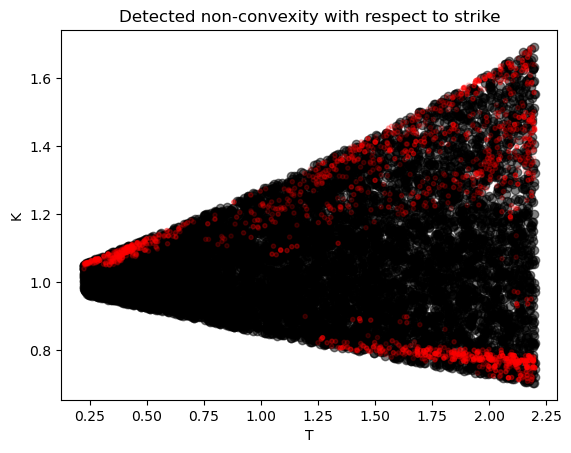

In [26]:
features_con_K, values = convexity_check(model_best, 0.1)

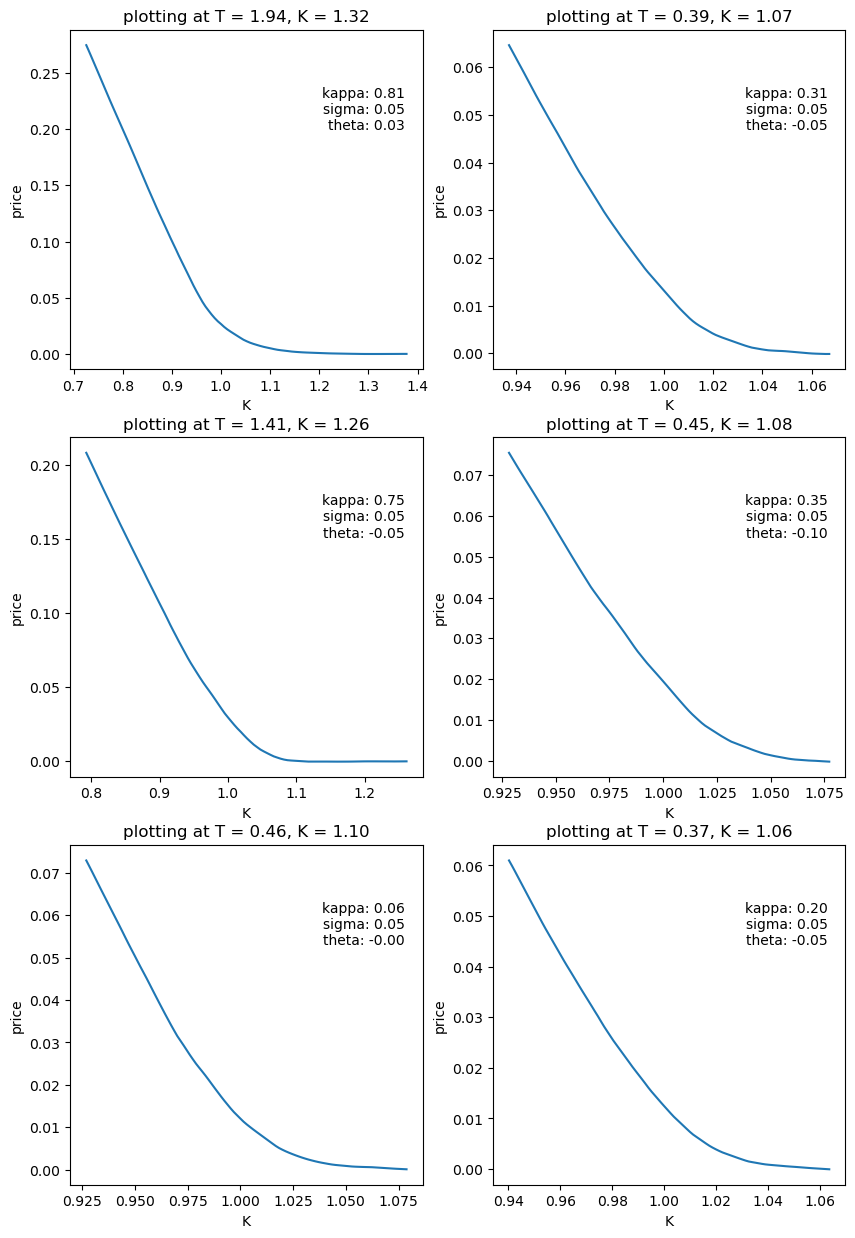

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
for index, i in enumerate(np.random.randint(0, features_con_K.shape[0], 6)):
    features_grid = np.tile(features_con_K[i], (len(grid_K), 1))
    features_grid[:, 1] = np.exp(0.33 * features_con_K[i, 0].item() * grid_K)
    pred_K = model_best(torch.from_numpy(features_grid).to(device)).detach().cpu().numpy()
    axes[index//2, index%2].plot(features_grid[:, 1], pred_K.squeeze())
    axes[index//2, index%2].set_title(f"plotting at T = {features_con_K[i, 0]:.2f}, K = {features_con_K[i, 1]:.2f}")
    str_param = ""
    for j, name in enumerate(input_columns[2:]):
        str_param += name + f": {features_con_K[i, j+2]:.2f}\n"
    axes[index//2, index%2].text(0.95, 0.65, str_param, verticalalignment='bottom', horizontalalignment='right', transform=axes[index//2, index%2].transAxes)
    axes[index//2, index%2].set_xlabel("K")
    axes[index//2, index%2].set_ylabel("price")